In [11]:
from collections import namedtuple
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, fbeta_score, make_scorer
from imblearn.over_sampling import SMOTE

import presentation as p

data = pd.read_csv('data/creditcard/creditcard.csv').drop_duplicates()

# extracting test data
data_train, data_test = train_test_split(
    data,
    test_size=.2,
    random_state=404,
    stratify=data.Class
)

# resampling training data
#data_train_1 = data_train[data_train.Class==1]
#n = len(data_train_1)
#data_train_0 = resample(data_train[data_train.Class==0], n_samples=n, random_state=404)
#data_train_downsampled = pd.concat([data_train_0, data_train_1], axis=0)

# extracting training and testing features
X_train = data_train.drop(['Class', 'Time'], axis=1)
X_test = data_test.drop(['Class', 'Time'], axis=1)
y_train = data_train.Class
y_true = data_test.Class

# scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle the class imbalance using SMOTE
sm = SMOTE(random_state=404)
X_train_smote, y_train_smote = sm.fit_resample(X_train_scaled, y_train)
X_train_smote_reduced, y_train_smote_reduced = resample(X_train_smote, y_train_smote, n_samples=int(0.5*len(y_train_smote)), random_state=404)

def simple_confusion_matrix(y_true, y_pred, target):
    sns.heatmap(data=confusion_matrix(y_true, y_pred), annot=True, cmap=p.Colors.blues_c)
    plt.title(f'Confusion Matrix for Target "{target}"')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()
    sns.heatmap(data=confusion_matrix(y_true, y_pred), annot=True, cmap=p.Colors.purples_c)
    plt.title(f'Confusion Matrix for Target "{target}"')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

eval_result = namedtuple('EvaluationResult', ['model', 'accuracy', 'fbeta'])

def evaluate_model(model, X_test, y_true, beta, average, display_false_negatives=True, threshold=None):
    pred = (model.predict_proba(X_test)[:,1] > threshold).astype(int) if threshold else model.predict(X_test)
    acc = accuracy_score(y_true, pred)
    fbeta = fbeta_score(y_true, pred, beta=beta, average=average)
    print('\n-- Testing Results --')
    print(f'Accuracy    on Verification Data:\t{acc:.6f}')
    print(f'Fbeta scroe on Verification Data:\t{fbeta:.6f}\n')
    print(classification_report(y_true, pred))
    if display_false_negatives:
        total_attacks = y_true.value_counts().iloc[1]
        confusion = confusion_matrix(y_true, pred)
        false_negatives = confusion[1, 0]
        print(f'False negatives: {false_negatives} ({100 * false_negatives / total_attacks:.3f}% out of {total_attacks} attacks, {100 * false_negatives / len(y_true):.3f}% overall)\n')
    return eval_result(model, acc, fbeta)

In [12]:
# Create individual models for voting classification
random_forest = RandomForestClassifier(
    criterion='gini',
	max_depth=10,
	n_estimators=50,
	n_jobs=-1,
	random_state=404
)
logistic_regression = LogisticRegression(
    C=0.4,
	fit_intercept=True,
	n_jobs=-1,
	#penalty=None,
	random_state=404,
	tol=0.0001
)
#metrics = tf.keras.metrics.FBetaScore(beta=10., threshold=.5, average='weighted')
#neural_network = Sequential([
#    Input(
#        shape=(X_train.shape[1],),
#        batch_size=128
#    ),
#    Dense(64, activation='relu'),
#    Dense(64, activation='relu'),
#    #Dense(16, activation='relu'),
#    Dropout(.2),
#    Dense(1, activation='sigmoid'),
#])
#neural_network.compile(
#    loss='binary_crossentropy',
#    optimizer='adam',
#    metrics=[metrics, tf.keras.metrics.Accuracy()]
#    #metrics=['accuracy']
#)

In [13]:
from sklearn.neural_network import MLPClassifier
mlpc = MLPClassifier(
    hidden_layer_sizes=(64, 64, 16),
    activation='relu',
    solver='adam',
    #solver='sgd',
    alpha=0.0001,
    batch_size=128,
    learning_rate='constant',
    learning_rate_init=0.001,
    #learning_rate='adaptive',   # only works with solver='sgd'
    max_iter=1000
)

In [14]:
# Voting Classifier
voting_classifier = VotingClassifier([
    ('Random Forest', random_forest),
    ('Logistic Regression', logistic_regression),
    #('Neural Network', neural_network),
    ('Neural Network', mlpc),
], voting='soft', n_jobs=-1).fit(X_train_smote_reduced, y_train_smote_reduced)

In [15]:
y_pred = voting_classifier.predict(X_test_scaled)

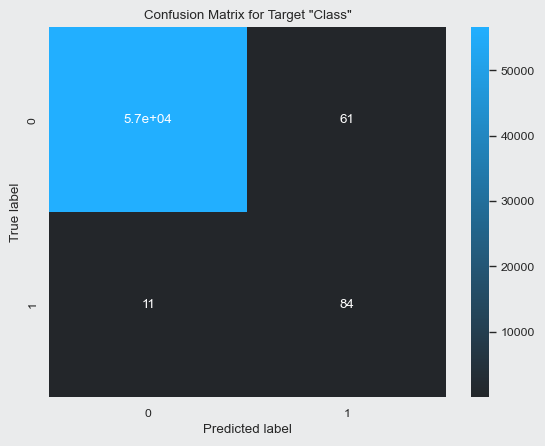

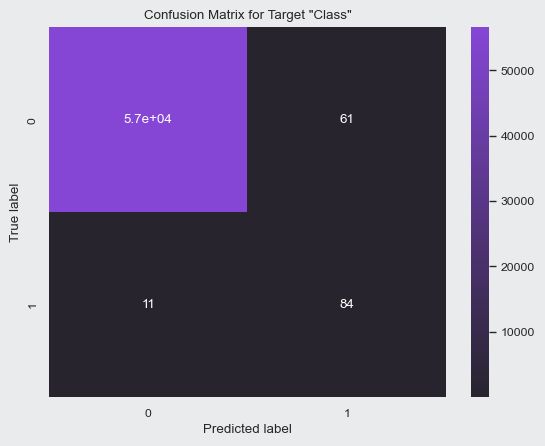

In [16]:
simple_confusion_matrix(y_true, y_pred, 'Class')

In [17]:
_ = evaluate_model(voting_classifier, X_test_scaled, y_true, beta=10, average='binary')


-- Testing Results --
Accuracy    on Verification Data:	0.998731
Fbeta scroe on Verification Data:	0.879627

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.58      0.88      0.70        95

    accuracy                           1.00     56746
   macro avg       0.79      0.94      0.85     56746
weighted avg       1.00      1.00      1.00     56746

False negatives: 11 (11.579% out of 95 attacks, 0.019% overall)



In [21]:
y_pred_proba = voting_classifier.predict_proba(X_test_scaled)[:,1]

In [33]:
threshold = 0.35
y_pred = (y_pred_proba > threshold).astype(int)

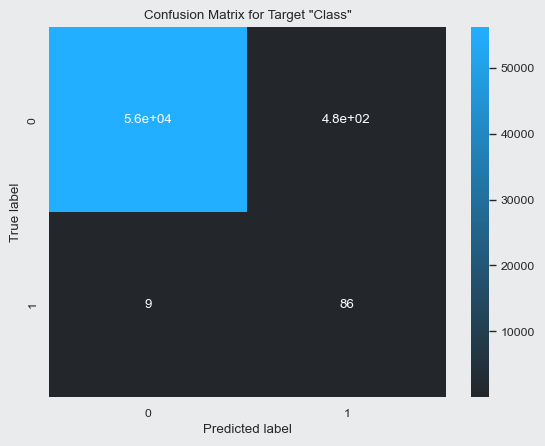

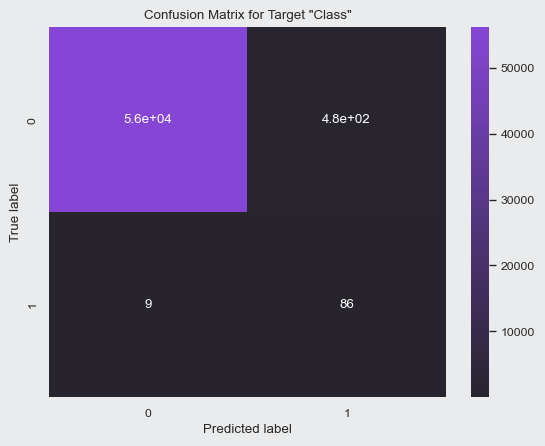

In [34]:
simple_confusion_matrix(y_true, y_pred, 'Class')

In [36]:
_ = evaluate_model(voting_classifier, X_test_scaled, y_true, beta=10, average='binary', threshold=threshold)


-- Testing Results --
Accuracy    on Verification Data:	0.991471
Fbeta scroe on Verification Data:	0.863334

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56651
           1       0.15      0.91      0.26        95

    accuracy                           0.99     56746
   macro avg       0.58      0.95      0.63     56746
weighted avg       1.00      0.99      0.99     56746

False negatives: 9 (9.474% out of 95 attacks, 0.016% overall)

